# General Problem

RS21 has a generalizable technique that can adddres two issues pertinent to the problem dscribed here
(accessed 5 Sep 2020, https://www.sbir.gov/node/1531895)

<blockquote>
    Current satellites move quickly into "safe mode" when experiencing an on-board anomaly. During the next few
days, the operators on the ground try to find the root cause of the problem using the information that the
spacecraft managed to download before/during the event. The Air Force is interested in investigating the use of
data mining and machine learning to process telemetry and anomaly messages on-board a satellite in real time,
determine root causes of anomalies, and select appropriate courses of action to mitigate system degradation
without defaulting to a "safe mode" response that terminates mission performance.
</blockquote>

The methods described have potential application in a wide range of problem domains. Time-to-event analysis goes by many different names. In healthcare, the general field is known as survival analysis, where it was developed to quantify estimates for the lifespans of populations. The machine learning powered improvements to traditional survival analysis described here can be applied to any situation where a population of components exists, and a custodian of those components needs to be able to predict when some of them will fail. Having a trusted quantitative estimate of when a specific component will fail then enables efficient intervention before the failure occurs.

# Demonstration Data

To demonstrate the technique we can use datasets from the NASA Prognostics Center of Excellence
(https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/)

<blockquote>
    The Prognostics Data Repository is a collection of data sets that have been donated by various universities, agencies, or companies. The data repository focuses exclusively on prognostic data sets, i.e., data sets that can be used for development of prognostic algorithms. Mostly these are time series of data from some nominal state to a failed state. The collection of data in this repository is an ongoing process.
</blockquote>

For demonstration purposes we use the Turbofan dataset:

```Reference: A. Saxena, K. Goebel, D. Simon, and N. Eklund, “Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation”, in the Proceedings of the Ist International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008.
```

```
Data Set: FD001
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: ONE (HPC Degradation)

Data Set: FD002
Train trjectories: 260
Test trajectories: 259
Conditions: SIX 
Fault Modes: ONE (HPC Degradation)

Data Set: FD003
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: TWO (HPC Degradation, Fan Degradation)

Data Set: FD004
Train trjectories: 248
Test trajectories: 249
Conditions: SIX 
Fault Modes: TWO (HPC Degradation, Fan Degradation)
Experimental Scenario

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine – i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:
1)  unit number
2)  time, in cycles
3)  operational setting 1
4)  operational setting 2
5)  operational setting 3
6)  sensor measurement  1
7)  sensor measurement  2
...
26) sensor measurement  26
```

This dataset has a series of time series measurements for each engine, and a corresponding column indicating the Remaining Useful Life (RUL).

The last row for each engine in this dataset has a RUL of zero. We create a new target variable for each record that is determined by the desired amount of lead time to failure.
Setting Time To Failure to 10 time cycles allows the latent precursor signals in the data to learn whether or not the RUL is <= 10. All records with RUL <= 10 (or whatever TTF is desired) have a new target label of 1, and all records where RUL > 10 have a new target label of 0.

With the data transformed in this way, a neural network binary classifier can be trained to predict the probability of a given sample to have label 0 or 1.

This general framework is applicable to any Time to Failure dataset.

The neural network is trained on such samples to learn whether the label is 0 or 1. Neural networks yield probablities for each class, not just strict class predictions. This fact enables the machine learning algorithm to learn the full hazard function, which can be written

$\lambda(\mathbf{X}_{i}, t_{j}) = P( Y = t_{j} | Y \geq t_{j} \mathbf{X}_{i})$.

The hazard function describes the probability that if a engine (satellite) has not expereinced failure (safe-mode transition) up until time $t_{j}$, how likely it is for it to fail within the calculated timeframe. $Y$ represents the true surival time. It follows that 
$P(Y = t_{j} | \mathbf{X}_{i}) = \lambda(\mathbf{X}_{i}, t_{j}) \prod_{k=1}^{j-1}(1 - \lambda(\mathbf{X}_{i}, t_{k}))$.

Knowing $P(Y = t_{j} | \mathbf{X}_{i})$ for all $t_{j}$ gives the full probability of transitioning to failure at time $Y$. The survival function is then derived from this distribution as 
$S(\mathbf{X}_{i}, t_{k}) = 1 = CDF(\mathbf{X}_{i}, t_{k})$
where
$CDF(\mathbf{X}_{i}, t_{k}) = \sum_{j=1}^{k}P(Y = t_{j} | \mathbf{X}_{i})$ is the cumulative density function.

The examples below will make this more concrete.

The training data in general will have a large class imbalance; far more samples will have a target value of 0 than 1. For the turbofan data in this demonstration, 95\% of the samples had a target class of 0, and the remaining 5\% had a target class of 1.

There are several established techniques to overcome this class imbalance problem. 

For this example, we perform oversampling on just the training set, so that the model sees more target class 1 examples.

In [1]:
from IPython.display import Image


The neural network had 5 layers and can be visualized below. 
each sample has 25 features, and produces a single output, the hazard function.

The Dropout layers are a deep learning method to precent overfitting of the model, so that the model learns the signal instead of the noise.

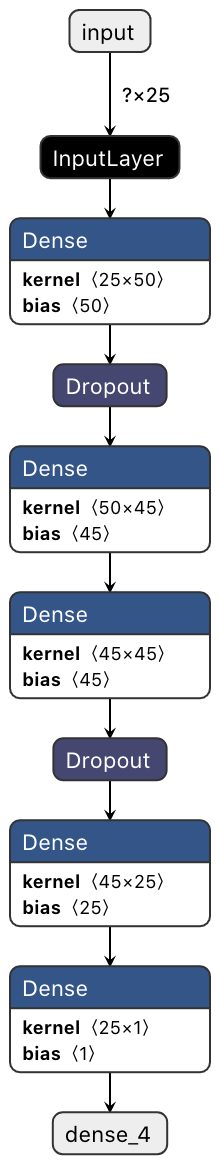

In [2]:
Image('model.png', embed=True)


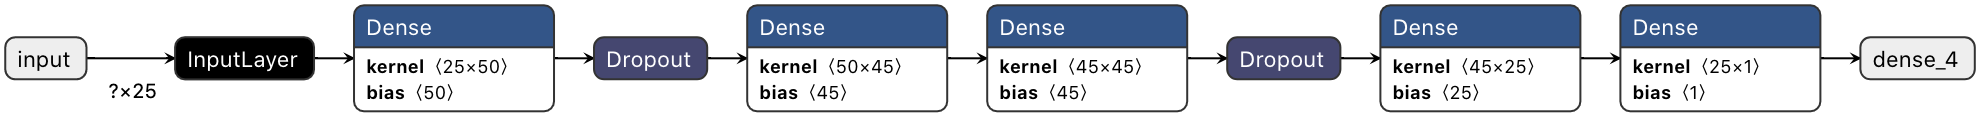

In [3]:
Image('model_horizontal.png',embed=True)

# Evaluation metrics

Evaluation metrics for the model scored on a hold out validation set of engines

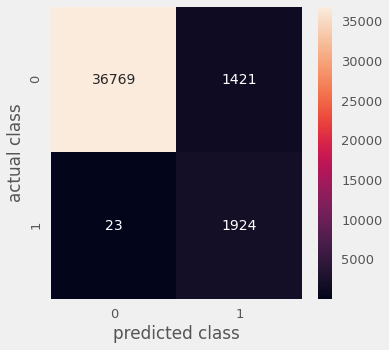

In [4]:
Image('confusion.png',embed=True)

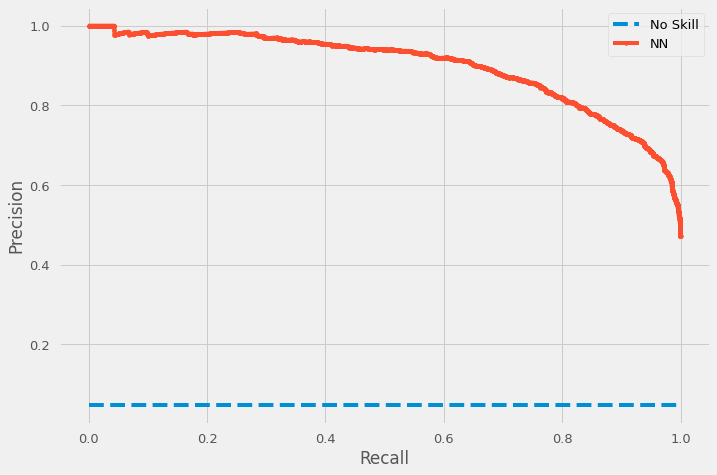

In [5]:
Image('precision_recall.png',embed=True)

```
  precision    recall  f1-score   support

           0       1.00      0.96      0.98     38190
           1       0.58      0.99      0.73      1947

    accuracy                           0.96     40137
   macro avg       0.79      0.98      0.85     40137
weighted avg       0.98      0.96      0.97     40137            
```

# Survival Curve Predictions 

The trained model can be deployed in real time go generate survival curves for streaming data.

Below are example curves for engines unseen during training. The black line indicates when that engine actually has a RUL dip below 10:

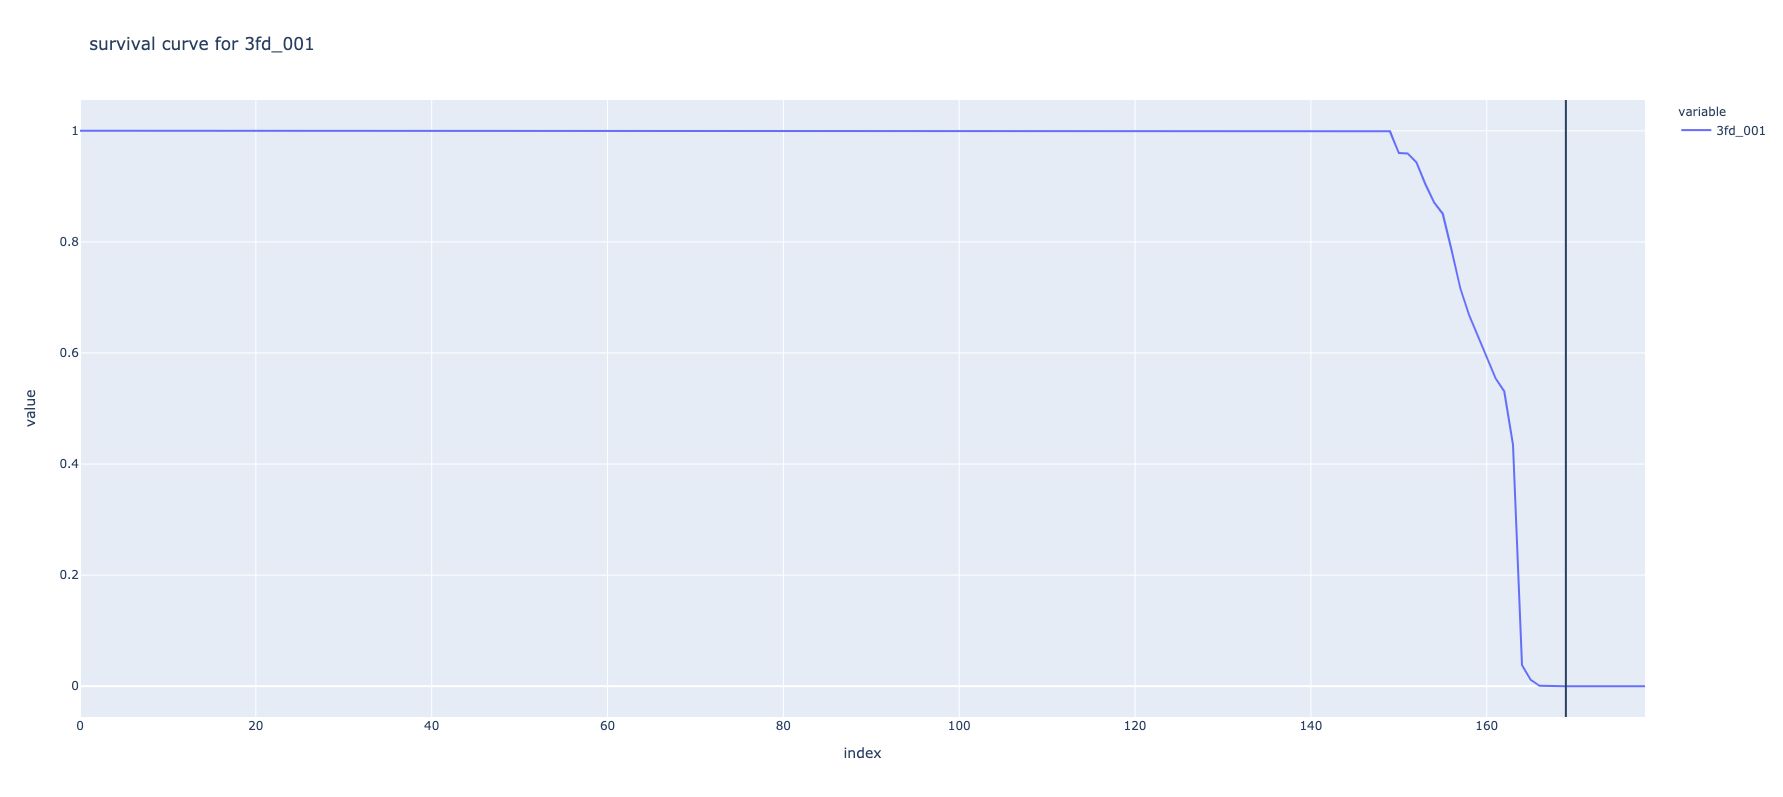

In [6]:
Image('sc_3fd_001.png',embed=True)

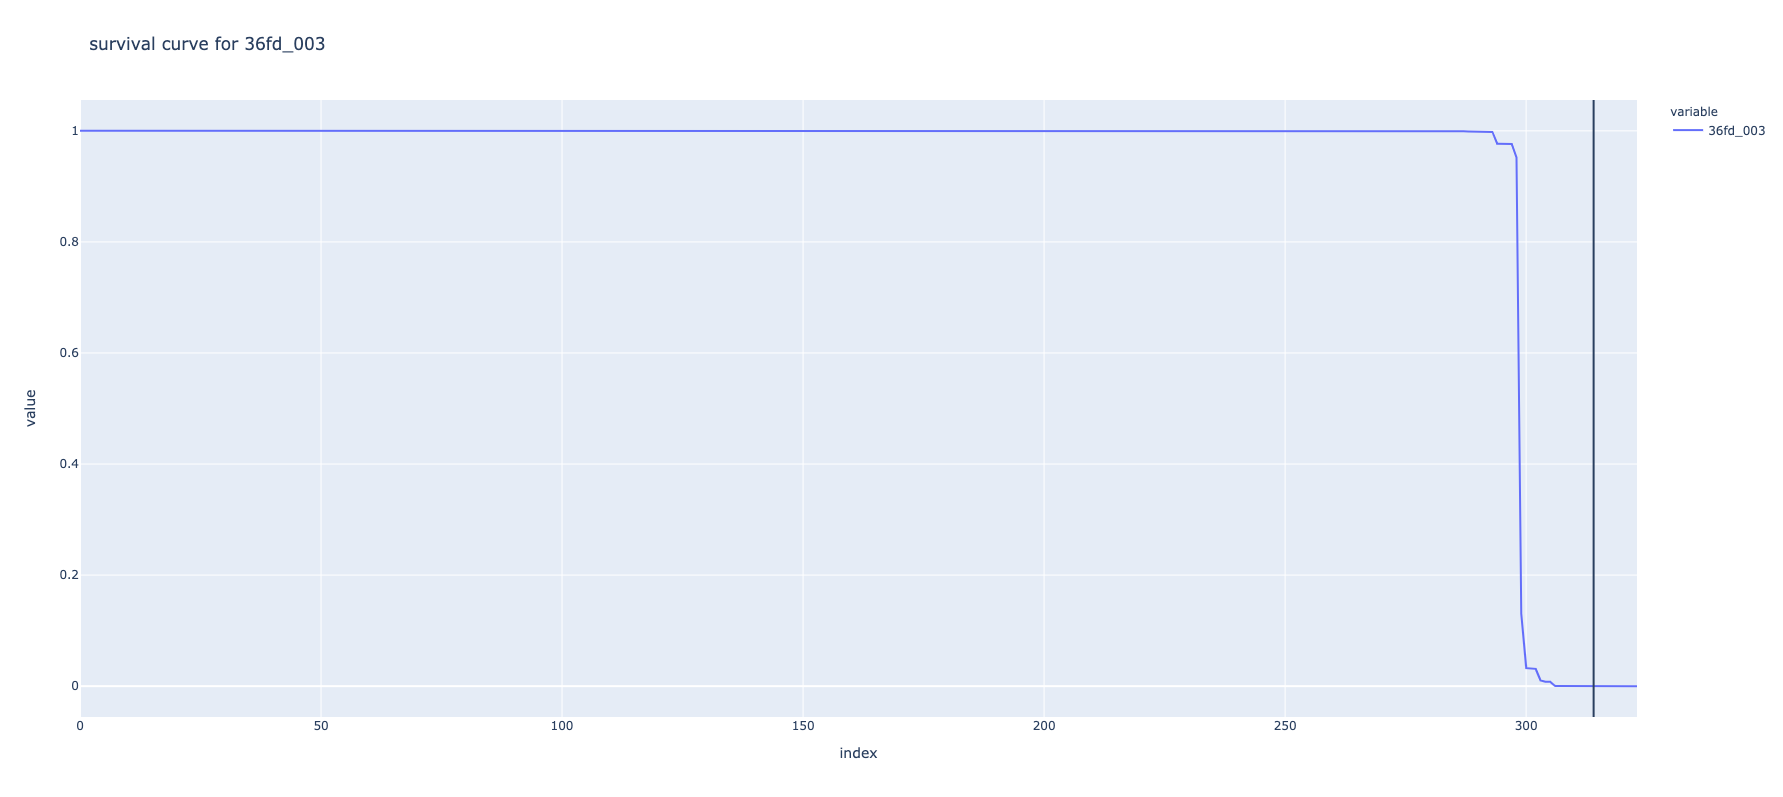

In [7]:
Image('sc_36fd_003.png',embed=True)

The False Positives in the confusion matrix are all just barely missing the TTF window of 10 or less RUL. 
The model is learning precursor signals in the input data and sometimes firing a little early, but in such a way that it is not a false alarm. This is an indication that this particular dataset could support an even larger early waraning window. A TTF greater than 10 could be supported and predictions made.




Below is an example parallel coordinate plot that allows for interactive filtering to see the difference between the low RUL points. Green traces correspond to closer to failure samples, different combinations and filters can be explored to diagnose what causes the different failure modes to trigger.

In [9]:
from IPython.display import HTML

In [11]:
HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="parallel_recording.mov" type="video/mp4">
</video></div>""")